In [1]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
from pyiron_atomistics import Project
import inspect
from cwl_helpers import *

2022-11-12 16:46:21,173 - pyiron_log - WARNING - Configuration file may be read by others - check permissions to secure credential information!
/home/menon/miniconda3/envs/pyiron-atom-dev/lib/python3.10/site-packages/paramiko-2.10.3-py3.10.egg/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
/home/menon/miniconda3/envs/pyiron-atom-dev/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: NOT-A-GIT-REPOSITORY is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
ev_to_j = sc.physical_constants["electron volt-joule relationship"][0]
Av =  sc.physical_constants["Avogadro constant"][0]
A_to_m = 1E-10
kB = sc.physical_constants["Boltzmann constant"][0]

In [3]:
input_list = { 
    "projectname": "cp_t5",
    "element": "Al",
    "repetitions": (4,4,4),
    "temperature": 293,
    "pressure": 0,
    "potential": '2008--Mendelev-M-I--Al--LAMMPS--ipr1',
    "atomic_mass": 26.98 }

In [4]:
cwl = create_cwldict()

In [5]:
add_to_inputs(cwl, input_list)

In [6]:
@generate_step(cwl, ins={"projectname": "projectname"}, outs=["modprojectname"])
def create_project(projectname = None):
    pr = Project(projectname)
    return projectname

In [7]:
@generate_step(cwl, ins={"projectname": "create_project/modprojectname", "element":"element",
                        "repetitions":"repetitions"}, outs=["outfile", "natoms"])
def create_structure(projectname = None, element=None, repetitions=(4,4,4)):
    pr = Project(projectname)
    inspect_res = inspect.stack()
    structure = pr.create.structure.bulk(element, cubic=True).repeat(repetitions)
    natoms = len(structure)
    outfile = "initial_structure.data"
    structure.write(outfile, format="vasp")
    return outfile, natoms

In [8]:
@generate_step(cwl, ins={"projectname": "create_project/modprojectname", "structure":"create_structure/outfile",
                        "temperature":"temperature", "pressure":"pressure",
                        "potential":"potential"}, outs=["equil_structure"])
def equilibriate_structure(projectname=None, structure=None, temperature=None, 
                          pressure=None, potential=None):
    pr = Project(projectname)
    job = pr.create.job.Lammps("job1", delete_existing_job=True,
                              delete_aborted_job=True)
    structure = pr.create.structure.read(structure, format="vasp")
    job.structure = structure
    job.potential = potential
    job.calc_md(temperature=temperature, 
                pressure=pressure, 
                n_ionic_steps=1000, 
                initial_temperature=temperature)
    job.run()
    eq_struct = job.get_structure()
    outfile = "equilibrium_structure.data"
    eq_struct.write(outfile, format="vasp")
    return outfile    

In [9]:
@generate_step(cwl, ins={"projectname": "create_project/modprojectname", "structure":"equilibriate_structure/equil_structure",
                        "temperature":"temperature", "pressure":"pressure",
                        "potential":"potential"}, outs=["energy_total", "volume"])
def get_energy_volume(projectname=None, structure=None, temperature=None, 
                          pressure=None, potential=None):
    pr = Project(projectname)
    job = pr.create.job.Lammps("job2", delete_existing_job=True,
                              delete_aborted_job=True)
    structure = pr.create.structure.read(structure, format="vasp")
    job.structure = structure
    job.potential = potential
    job.calc_md(temperature=temperature, 
                pressure=pressure, 
                n_ionic_steps=1000, 
                initial_temperature=temperature,
                n_print=100)
    job.run()
    energy_total = job.output.energy_tot
    volume = job.output.volume
    return energy_total, volume

In [10]:
@generate_step(cwl, ins={"energy":"get_energy_volume/energy_total", "no_atoms": "create_structure/natoms",
                        "temperature": "temperature", "atomic_mass": "atomic_mass"}, outs=["cp"])
def calculate_cp(energy=None, no_atoms=None, 
                 temperature=None, atomic_mass=None):
    emean = np.mean(energy)
    efluct = energy - emean
    efluctsq = (efluct*ev_to_j)**2
    cp = np.mean(efluctsq)/(kB*temperature*temperature)
    w = (no_atoms/Av)*1E3*atomic_mass
    cp = (cp/w)*1000
    return cp

In [11]:
@generate_step(cwl, ins={"energy":"get_energy_volume/energy_total", "volume": "get_energy_volume/energy_total",
                        "temperature": "temperature"}, outs=["ap"])
def calculate_ap(energy=None, volume=None, temperature=None):
    emean = np.mean(energy)
    efluct = energy - emean
    crossfluct = (efluct*ev_to_j)*(volume - np.mean(volume))
    ap = np.mean(crossfluct)/(kB*temperature*temperature*np.mean(volume))
    return ap

In [12]:
projectname = create_project(projectname = input_list["projectname"])
projectname

'cp_t5'

In [13]:
structure, no_atoms = create_structure(projectname=projectname, element=input_list["element"],
                            repetitions=input_list["repetitions"])
structure, no_atoms

('initial_structure.data', 256)

In [14]:
equil_structure = equilibriate_structure(projectname=projectname, 
                          structure=structure, 
                          temperature=input_list["temperature"], 
                          pressure=input_list["pressure"], 
                          potential=input_list["potential"])
equil_structure

The job job1 was saved and received the ID: 359


'equilibrium_structure.data'

In [15]:
energy, volume = get_energy_volume(projectname=projectname, structure=equil_structure, 
                          temperature=input_list["temperature"], 
                          pressure=input_list["pressure"], 
                          potential=input_list["potential"])

The job job2 was saved and received the ID: 360


In [16]:
cp = calculate_cp(energy=energy, no_atoms=no_atoms, 
                 temperature=input_list["temperature"], atomic_mass=input_list["atomic_mass"])
cp

0.9672912142193067

In [17]:
ap = calculate_ap(energy=energy, volume=volume, temperature=input_list["temperature"])
ap

7.972319362290918e-05

In [18]:
cwl["outputs"] = {}
cwl["outputs"]["cp"] = {}
cwl["outputs"]["cp"]["type"] = "float"
cwl["outputs"]["cp"]["outputSource"] = "calculate_cp/cp"
cwl["outputs"]["ap"] = {}
cwl["outputs"]["ap"]["type"] = "float"
cwl["outputs"]["ap"]["outputSource"] = "calculate_ap/ap"

In [19]:
import yaml

In [20]:
with open("recipe_auto.cwl", "w") as fout:
    yaml.safe_dump(cwl, fout)

In [21]:
import graphviz

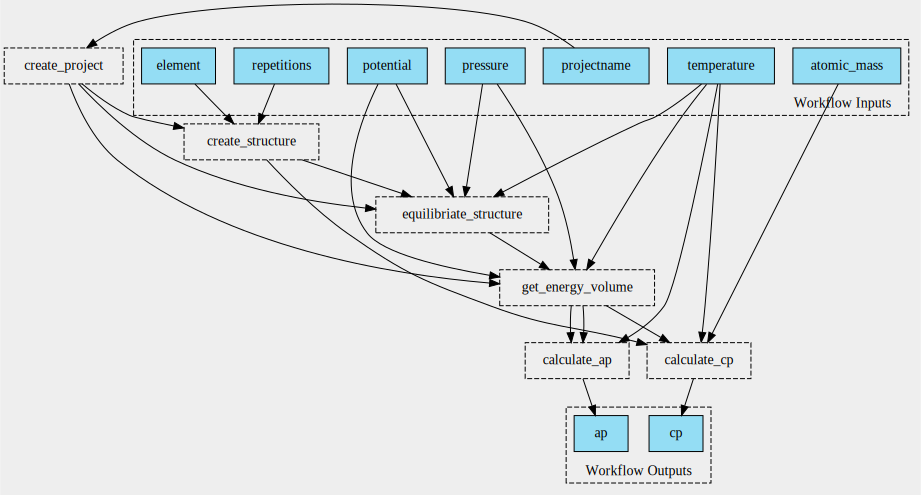

In [22]:
graphviz.Source.from_file('gp.gv')

In [26]:
a = np.array([1,2])

In [28]:
type(a).__name__

'ndarray'

In [31]:
type(a[0]).__name__

'int64'